### Decision Trees 决策树

In [15]:
import numpy as np
import pandas as pd

np.random.seed(42)

import os
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)


In [4]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and with
y = iris.target

In [12]:
print(iris.feature_names)
pd.DataFrame(iris.data).head(2)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2


In [11]:
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [17]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True
)

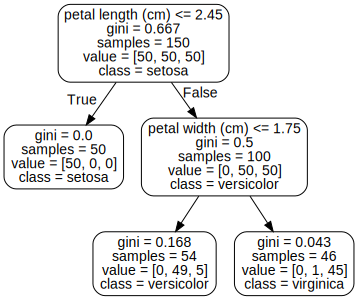

In [19]:
from graphviz import Source
Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

- samples: 训练样本
- values: 分配到该节点的每个分类中的样本数目 
- gini: 测量它的纯度：如果一个节点包含的所有训练样例全都是同一类别的，我们就说这个节点是纯的（Gini=0）。上图深度2左边节点： $1 – (0/54)^2 – (49/54)^2 – (5/54)^2 ≈ 0.168$    

**Gini impurity**

$
G_i = 1 - \sum\limits_{k=1}^{n}{{p_{i,k}}^2}
$

### 决策边界

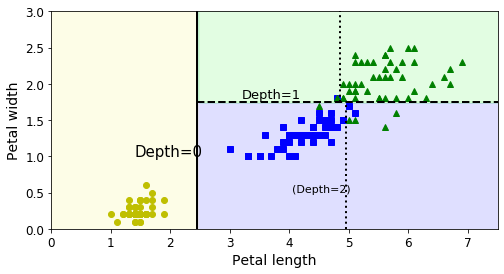

In [23]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

plt.show()

### 估计分类概率
针对每个样本可以估计它属于某个分类的概率，就是根据决策树中的values 计算，分类到同一个叶子节点的实例的概率都一样

In [24]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [25]:
tree_clf.predict([[5, 1.5]])

array([1])

### CART 训练算法
Scikit-Learn 用分裂回归树（Classification And Regression Tree，简称 CART）算法训练决策树（也叫“增长树”）。这种算法思想真的非常简单：

首先使用单个特征k和阈值 t_k（例如，“花瓣长度≤2.45cm”）将训练集分成两个子集。它如何选择k和 t_k 呢？它寻找到能够产生最纯粹的子集一对 (k, t_k)，然后通过子集大小加权计算。    

**CART cost function for classification**

$
\begin{split}
&J(k, t_k) = \dfrac{m_{\text{left}}}{m}G_\text{left} + \dfrac{m_{\text{right}}}{m}G_{\text{right}}\\
&\text{where }\begin{cases}
G_\text{left/right} \text{ measures the impurity of the left/right subset 测量左右子集的纯度,}\\
m_\text{left/right} \text{ is the number of instances in the left/right subset 左右子集实例的个数.}
\end{cases}
\end{split}
$    
     
    
递归重复上面的计算，直到达到最大深度（max_depth）或者是它找不到可以继续降低不纯度的分裂方法的时候。

### 计算复杂度
在建立好决策树模型后， 做出预测需要遍历决策树， 从根节点一直到叶节点。决策树通常近似左右平衡，因此遍历决策树需要经历大致 O(log_2m)个节点。由于每个节点只需要检查一个特征的值，因此总体预测复杂度仅为 O(log_2m)，与特征的数量无关。 所以即使在处理大型训练集时，预测速度也非常快。

### 基尼不纯度或是信息熵
通常，算法使用 Gini 不纯度来进行检测， 但是你也可以通过将标准超参数设置为"entropy"来使用熵不纯度进行检测。   
在机器学习中，熵经常被用作不纯度的衡量方式，当一个集合内只包含一类实例时， 我们称为数据集的熵为 0。     
depth-2 left node 熵是 $ -\frac{49}{54}\log_2(\frac{49}{54}) - \frac{5}{54}\log_2(\frac{5}{54}) $。    
   
**Entropy**    
    
$
H_i = -\sum\limits_{k=1 \atop p_{i,k} \ne 0}^{n}{{p_{i,k}}\log_2(p_{i,k})}
$


### 正则化超参数
如果不加任何限制，决策树将会过拟合数据，所以需要添加正则化超参数。   
- max_depth: 最大深度
- min_samples_split: node 节点超过多少样本数目才能继续分割
- min_weight_fraction_leaf: 和min_samples_leaf相同，但表示为加权总数的一小部分实例
- max_leaf_nodes: 叶节点的最大数量
- max_features: 在每个节点被评估是否分裂的时候，具有的最大特征数量

### 回归

In [27]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [28]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

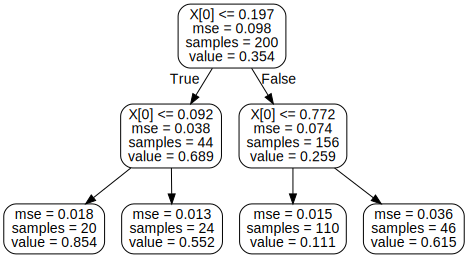

In [30]:
export_graphviz(
    tree_reg,
    out_file=os.path.join(IMAGES_PATH, "moon_regressor.dot"),
    rounded=True
)
Source.from_file(os.path.join(IMAGES_PATH, "moon_regressor.dot"))

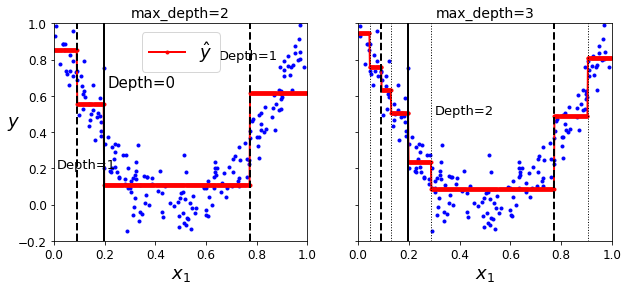

In [31]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

CART 算法的工作方式与之前处理分类模型基本一样，不同之处在于，现在不再以最小化不纯度的方式分割训练集，而是试图以最小化 MSE 的方式分割训练集。   
    
**CART cost function for regression**

$
J(k, t_k) = \dfrac{m_{\text{left}}}{m}\text{MSE}_\text{left} + \dfrac{m_{\text{right}}}{m}\text{MSE}_{\text{right}} \quad
\text{where }
\begin{cases}
\text{MSE}_{\text{node}} = \sum\limits_{\scriptstyle i \in \text{node}}(\hat{y}_{\text{node}} - y^{(i)})^2\\
\hat{y}_\text{node} = \dfrac{1}{m_{\text{node}}}\sum\limits_{\scriptstyle i \in \text{node}}y^{(i)}
\end{cases}
$

### 不稳定性
1. 决策树很喜欢设定正交化的决策边界，（所有边界都是和某一个轴相垂直的），这使得它对训练数据集的旋转很敏感，
2. 它对训练数据的微小变化非常敏感